In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import pairwise
from PIL import Image
%matplotlib inline

(2400, 1080, 3)

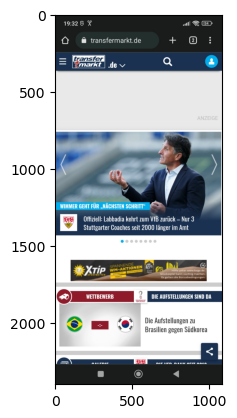

In [14]:
PATH = '../cropbundle/src/androidTest/assets/defective/Screenshot_2022-12-05-19-32-46-561_com.android.chrome.jpg'

img = mpimg.imread(PATH)
plt.imshow(img)
img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2400, 1080, 3)

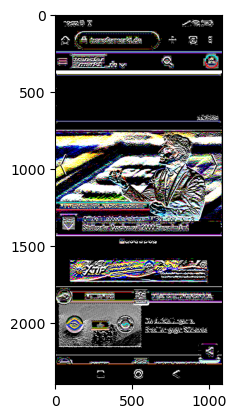

In [15]:
def sobel(image, dy):
    return cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=0, dy=dy, ksize=5)

sobel_y_1d = sobel(img, 1)
sobel_y_2d = sobel(img, 2)

plt.imshow(sobel_y_1d)

sobel_y_2d.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


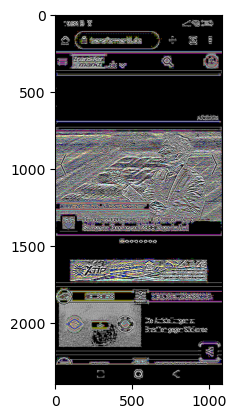

In [16]:
plt.imshow(sobel_y_2d)

(2400, 1080)

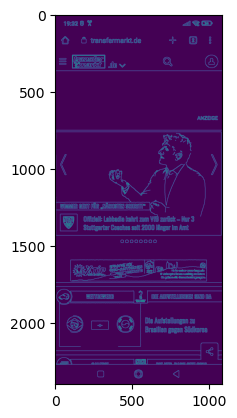

In [17]:
canny = cv2.Canny(img, 100, 200)
plt.imshow(canny)
canny.shape

(2400, 1080)

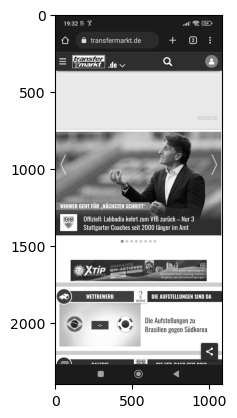

In [18]:
img_gray = np.asarray(Image.open(PATH).convert('L'))
plt.imshow(img_gray, cmap='gray')
img_gray.shape

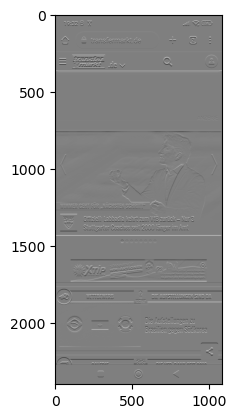

In [19]:
sobel_y_gray = sobel(img_gray, 1)
plt.imshow(sobel_y_gray, cmap='gray')

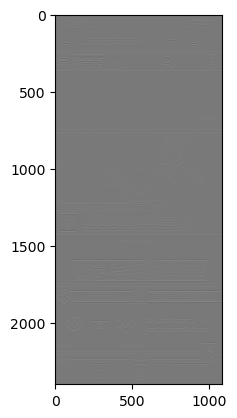

In [20]:
sobel_y_gray = sobel(img_gray, 2)
plt.imshow(sobel_y_gray, cmap='gray')

array([  0, 255], dtype=uint8)

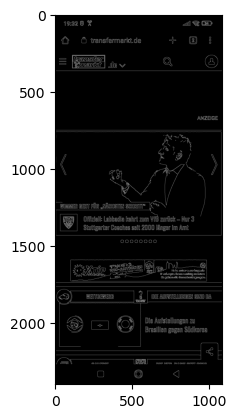

In [21]:
canny_gray = cv2.Canny(img_gray, 100, 200)
plt.imshow(canny_gray, cmap='gray')
np.unique(canny_gray.flatten())

In [22]:
def edge_candidates(img_binary, row_mean_threshold):
    candidates = []
    for i, row in enumerate(img_binary):
        if np.mean(row) > row_mean_threshold:  # TODO: optimize
            candidates.append(i)  # MAYBE: only add rows which are located within a certain distance from previous row
    
    return candidates

candidates = edge_candidates(canny_gray, 200)
candidates

[368, 753, 1435, 1733, 1741, 1768, 1796, 2184, 2211, 2239]

In [23]:
def crop_area(img, edges):
    return img[edges[0]:edges[1], 0:img.shape[1]]

def crop_height(edges):
    return edges[1] - edges[0]

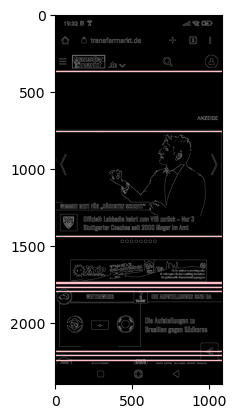

In [24]:
for c in candidates:
    plt.plot([0, img_gray.shape[1]], [c, c], color='pink', linewidth=1)
plt.imshow(canny_gray, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(753, 1435)


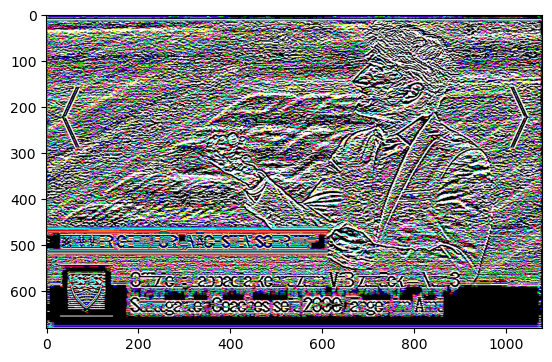

In [25]:
def crop_edges(candidates, img_sobel):
    height = img_sobel.shape[0]
    img_clipped = np.clip(img_sobel, 0, 1)
    
    # add start and end row to candidates 
    candidates = [0] + candidates + [height]
    
    max_score = -1
    max_score_edge_pair = None
    
    for edges in pairwise(candidates):
        area = crop_area(img_clipped, edges)
        fluctuation = np.mean(area)
        height_proportion = crop_height(edges) / height
        score = fluctuation * height_proportion
        
        if score > max_score:
            max_score = score
            max_score_edge_pair = edges
            
    return max_score_edge_pair

edges = crop_edges(candidates, sobel_y_2d)
area = crop_area(sobel_y_2d, edges)

print(edges)
plt.imshow(area)

In [27]:
np.mean(sobel_y_2d)
print(np.min(sobel_y_2d))
print(np.max(sobel_y_2d))

clipped = np.clip(sobel_y_2d, 0, 1)
print(clipped[0])

-7233.0
7847.0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [28]:
def crop_edges_candidates(img_path):
    gray_scale = np.asarray(Image.open(img_path).convert('L'))
    gray_scale_canny = cv2.Canny(gray_scale, 100, 200)
    return _edge_candidates(gray_scale_canny, 200)
    
def _edge_candidates(img_gray_scale, row_mean_threshold):
    candidates = []
    for i, row in enumerate(img_gray_scale):
        if np.mean(row) > row_mean_threshold:  # TODO: optimize
            candidates.append(i)  # MAYBE: only add rows which are located within a certain distance from previous row

    return candidates

def crop_edges_from_candidates(img_path, candidates):
    sobel = cv2.Sobel(src=np.asarray(Image.open(img_path)), ddepth=cv2.CV_64F, dx=2, dy=2, ksize=5)
    sobel_clipped = np.clip(sobel, 0, 1)
    
    height = sobel_clipped.shape[0]
    
    # add start and end row to candidates 
    candidates = [0] + candidates + [height]
    
    max_score = -1
    max_score_edge_pair = None
    
    for edges in pairwise(candidates):
        area = crop_area(sobel_clipped, edges)
        fluctuation = np.mean(area)
        height_proportion = crop_height(edges) / height
        score = fluctuation * height_proportion
        
        if score > max_score:
            max_score = score
            max_score_edge_pair = edges
            
    return max_score_edge_pair

def crop_edges(img_path):
    candidates = crop_edges_candidates(img_path)
    return crop_edges_from_candidates(img_path, candidates)

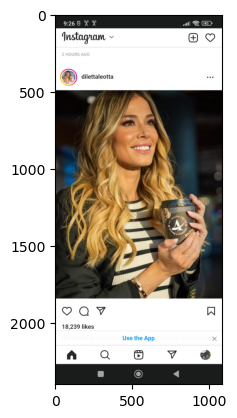

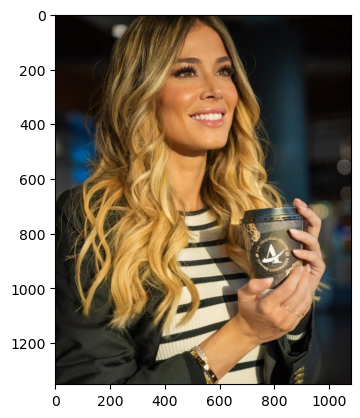

In [30]:
path = '../cropbundle/src/androidTest/assets/defective/Screenshot_2022-12-06-09-26-12-769_com.android.chrome.jpg'
img = np.asarray(Image.open(path))

plt.imshow(img)
plt.show()

edges = crop_edges(path)
plt.imshow(crop_area(img, edges))